# Model training- a house price predictor for Prime Estata Solutions

__Setting up the environment__

In [5]:
# Importing dependencies

import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(rc={'figure.figsize':(10,6)})
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
import warnings 
warnings. filterwarnings('ignore')
import joblib
from utils import create_pipeline


In [6]:
# loading in the train dataset

housing_data_train = pd.read_csv("data/Housing_dataset_train.csv")
housing_data_test = pd.read_csv("data/Housing_dataset_test.csv")


__Examining the data__

this is to:
- Get to know the data
- Identify potential dirty data issues

In [7]:
housing_data_train.head()

,ID,loc,title,bedroom,bathroom,parking_space,price
0,3583,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565
1,2748,Ondo,Apartment,NaN,2.0,4.0,1672416.689
2,9261,Ekiti,NaN,7.0,5.0,NaN,3364799.814
3,2224,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756
4,10300,Kogi,Terrace duplex,NaN,5.0,6.0,2600700.898


In [8]:
housing_data_train.shape

(14000, 7)

In [9]:
housing_data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             14000 non-null  int64  
 1   loc            12187 non-null  object 
 2   title          12278 non-null  object 
 3   bedroom        12201 non-null  float64
 4   bathroom       12195 non-null  float64
 5   parking_space  12189 non-null  float64
 6   price          14000 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 765.8+ KB


From the inspection of the data done so far:

The training data contains 14 thousand housing records with 7 fields (attributes/columns/variables), with descriptions as follows;

- ID: A unique number identifying each house
- loc (location): The state, in Nigeria, where the house is situated.
- title: A short caption telling us the house type.
- bedroom: The number of bedrooms in the house.
- bathroom: The number of bathrooms in the house.
- parking_space: I am assuming this is the size of the parking space but it could be the number of parking spaces available.
- price: The cost of the house, which is our target variable (The data we want to predict)

Of the 7 fields, 5 are numeric while 2 are categorical.

A peep into the dataset by getting the first 5 rows and, the result of calling the info() method on the data already show indication that there are missing values in this data. This is a dirty data issue. Let's confirm by checking directly for presence of missing values.

Other common dirty data issues that may be present in a dataset are:
- The presence of duplicate recors.
- Errors at data entry- e.g., spelling errors in categorical (string) fields, for example, a value in the 'loc' field indicating 'Lagos' could be spelled as 'lagos', or 'Logas', etc.

We will also check for these dirty data issues.

In [10]:
# Checking for missing values

housing_data_train.isna().sum()

ID                  0
loc              1813
title            1722
bedroom          1799
bathroom         1805
parking_space    1811
price               0
dtype: int64

Only the ID and price field do not have missing values.
The ID field is not needed in this modeling use-case so, leaves us with the price field as the only clean field.

In [11]:
# Checking for duplicates

print(f"There are {housing_data_train.duplicated().sum()} duplicated records in the train dataset)")

There are 0 duplicated records in the train dataset)


In [12]:
# inspecting the 'loc' and 'title' fields

housing_data_train["loc"].unique()

array(['Katsina', 'Ondo', 'Ekiti', 'Anambra', 'Kogi', 'Borno', 'Kwara',
       'Osun', 'Kaduna', 'Ogun', 'Bayelsa', nan, 'Abia', 'Rivers',
       'Taraba', 'Ebonyi', 'Kebbi', 'Enugu', 'Edo', 'Nasarawa', 'Delta',
       'Kano', 'Yobe', 'Benue', 'Bauchi', 'Cross River', 'Niger',
       'Adamawa', 'Plateau', 'Imo', 'Oyo', 'Zamfara', 'Sokoto', 'Jigawa',
       'Gombe', 'Akwa Ibom', 'Lagos'], dtype=object)

In [13]:
housing_data_train["loc"].nunique()

36

In [14]:
housing_data_train.title.unique()

array(['Semi-detached duplex', 'Apartment', nan, 'Detached duplex',
       'Terrace duplex', 'Mansion', 'Bungalow', 'Penthouse', 'Townhouse',
       'Flat', 'Cottage'], dtype=object)

There are no duplicate records but we've confirmed that there are missing values and for the missing values, it can be seen that only a small proportion of the total data size is missing, for the fields affected. If a large proportion was missing for any field, we would possibly have been considering options like dropping that field entirely because, with most of its values missing, it can influence poor model performance.

Also, there are no noticable variance in spelling for any of the values in the 'loc' and 'title' fields.

And, it can also be seen that the houses represented in the dataset span across the 36 states of Nigeria.

Before we address these missing values, let's also inspect the test data. 

This is because, if there are dirty data issues, like missing values, for example, in the test dataset, we will be using whatever inputs we are using to fill in missing values in the train data to also fill those in the test data.

Why? The goal is to develop a model that is independent of our test data and can still generalise well when it sees entirely new data. By Machine learning practice, The test data will not control the model's outcome; the training data does. for example, if you train a model with 10 fields and you try to pass a test data with 11 fields to it at inference, you will get an error letting you know the additional field was not factored in at training.

In [15]:
# examining the test data

housing_data_test.shape

(6000, 6)

In [16]:
housing_data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             6000 non-null   int64 
 1   loc            6000 non-null   object
 2   title          6000 non-null   object
 3   bedroom        6000 non-null   int64 
 4   bathroom       6000 non-null   int64 
 5   parking_space  6000 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 281.4+ KB


In [17]:
housing_data_test.isna().sum()

ID               0
loc              0
title            0
bedroom          0
bathroom         0
parking_space    0
dtype: int64

In [18]:
# checking for mis-spellings

housing_data_test["loc"].unique()

array(['Kano', 'Adamawa', 'Lagos', 'Gombe', 'Edo', 'Niger', 'Anambra',
       'Benue', 'Ogun', 'Kogi', 'Taraba', 'Yobe', 'Zamfara', 'Borno',
       'Enugu', 'Ekiti', 'Delta', 'Osun', 'Oyo', 'Bauchi', 'Kwara',
       'Katsina', 'Cross River', 'Ondo', 'Akwa Ibom', 'Nasarawa',
       'Ebonyi', 'Plateau', 'Kaduna', 'Sokoto', 'Kebbi', 'Bayelsa',
       'Jigawa', 'Abia', 'Rivers', 'Imo'], dtype=object)

In [19]:
housing_data_test["loc"].nunique()

36

In [20]:
housing_data_test.title.unique()

array(['Penthouse', 'Apartment', 'Bungalow', 'Mansion',
       'Semi-detached duplex', 'Detached duplex', 'Flat', 'Townhouse',
       'Cottage', 'Terrace duplex'], dtype=object)

There are no missing values in the test data. 

No noticable mis-spelling errors too.

The presence of duplicates records in the test data doesn't matter much because, at inference, I believe a user is allowed to send the same request to the predictor app that will result from this model as many times as they want so, we leave that out.

__Data Cleaning__

Now, let's fill in the missing values.

The fields with missing values are; loc, title, bedroom, bathroom, parking_space

bedroom, bathroom and parking_sapce are numeric colums. 

To make the decision on filling the missing values, we have to check their distributions. If the distribution is normal, we fill with the mean of the values in that field, if skewed then it means that there are outliers, so, we fill with the median. We are not filling with the mean because the mean, as a measure of central tendency is bias towards outliers. The median is more objective in this scenario.

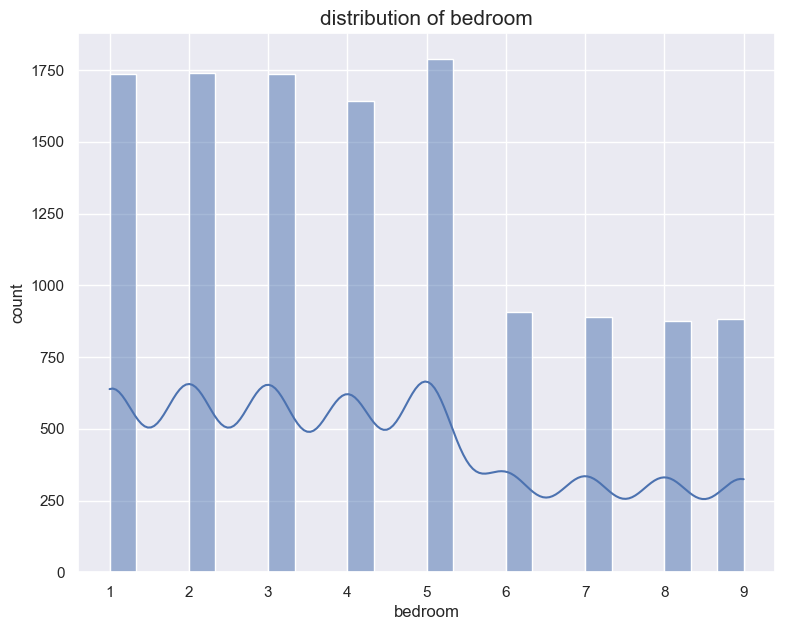

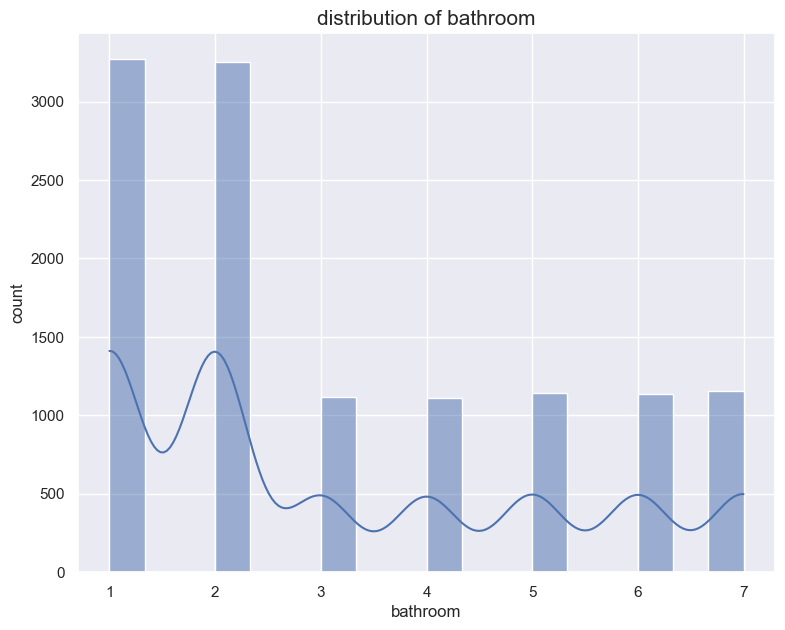

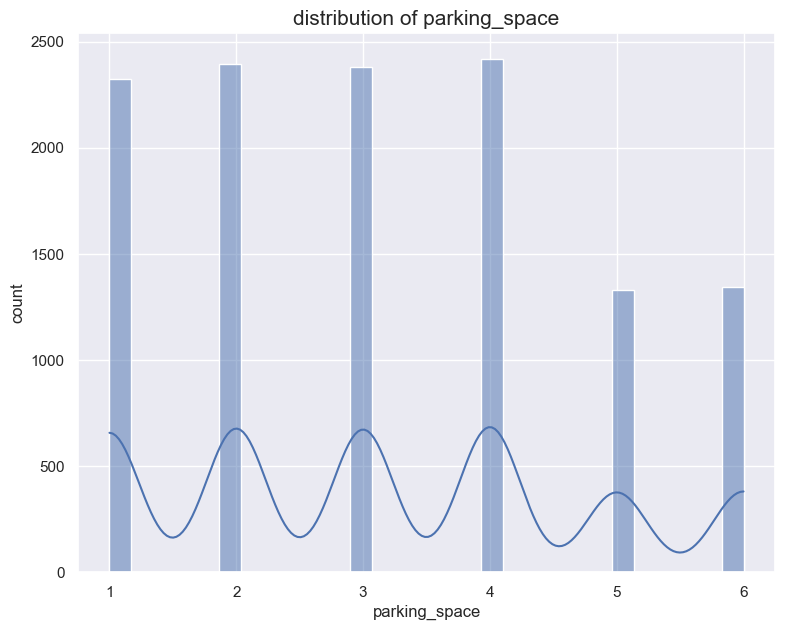

In [21]:
# Checking distribution of bedroom, bathroom and parking_space
for col in housing_data_train:
    if housing_data_train[col].dtype != "object" and col not in ["ID", "price"]:
        plt.figure(figsize=(9, 7))
        sns.histplot(data=housing_data_train, x=col, kde=True)
        plt.title(f"distribution of {col}", fontsize=15)
        plt.xlabel(col, fontsize=12)
        plt.ylabel("count", fontsize=12)
        plt.show()

Not very pronoused, but, the distributions for these three fields appear right-skewed. Let's confirm with a box plot.

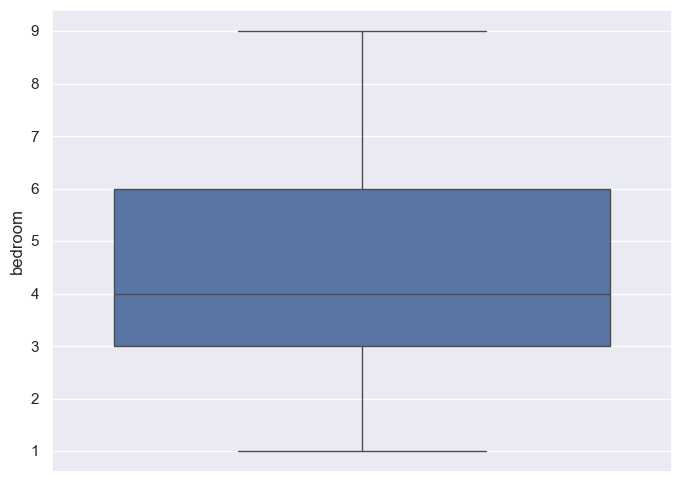

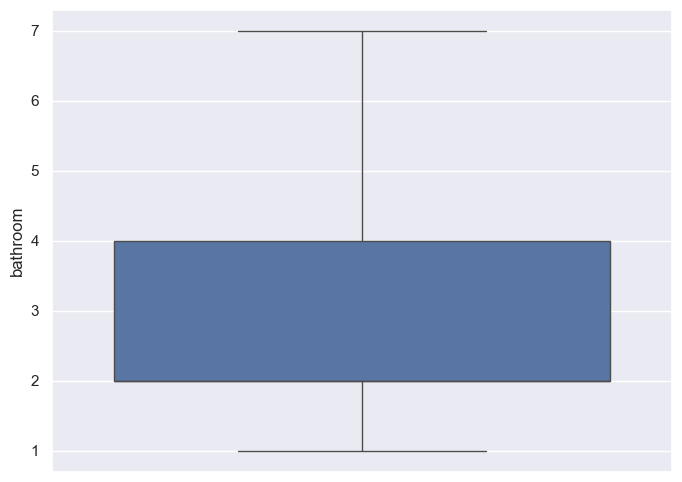

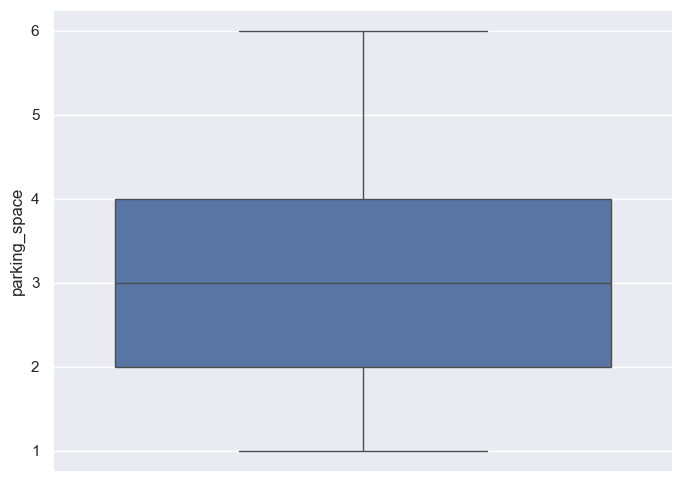

In [28]:
for col in housing_data_train:
    if housing_data_train[col].dtype != "object" and col not in ["ID", "price"]:
        plt.figure(figsize = (8, 6))
        sns.boxplot(housing_data_train[col])
        plt.show()

Yes, the fields do not have normal distributions. While there are no noticabe outliers, there are more lower values for these fields than higher. For example, there are more houses with 1, 2, 3, 4, 5 bathrooms than there are with 6, 7 bathrooms. Even by observation in reality, this looks to be the case.

So, we fill these three fields with the median of their available values

In [23]:
# Filling missing values in the three numeric feature variables- bedroom, bathroom, parking_space

for col in housing_data_train.columns:
    if housing_data_train[col].dtype != "object" and col not in ["ID", "price"]:
        housing_data_train[col] = housing_data_train[col].fillna(housing_data_train[col].median())


Now, to fill missing values in the categorical columns, which are the loc and title fields, we fill with the mode- that is the most frequently occuring value in each of those fields

In [24]:
# filling missing values in the loc and title fields

for col in housing_data_train.columns:
    if housing_data_train[col].dtype == "object":
        most_frequent_value = housing_data_train[col].value_counts().index[0]
        housing_data_train[col] = housing_data_train[col].fillna(most_frequent_value)

In [25]:
# Let's confirm there are no more missing values

housing_data_train.isna().sum()

ID               0
loc              0
title            0
bedroom          0
bathroom         0
parking_space    0
price            0
dtype: int64

There are no more missing values in the training data. 

Let's do a few exploratory data analysis and then, we proceed to model development.

- WHich house type (title) is the most expensive, on average?
- What are the top 5 locations with the most expensive houses?, let's see if the states of any of the major cities in Nigeria, like lagos. PH, are in the top 5.
- Which of bedroom, bathroom and packing_space is more likely to contribute to a higher price?

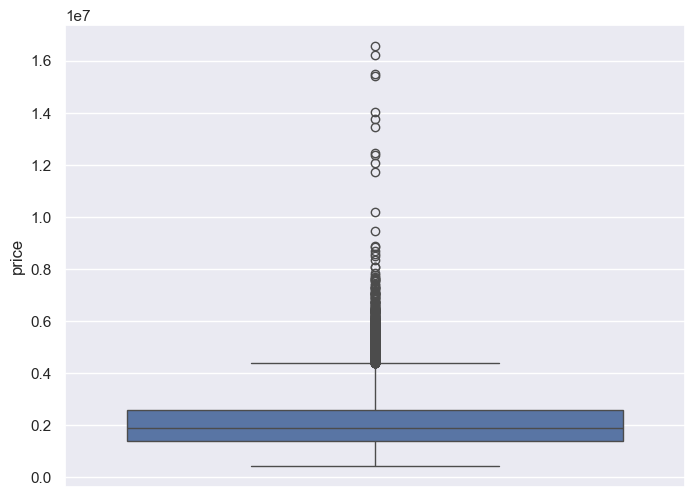

In [27]:
# Which house type (title) is the most expensive, on average?

# First, let's check if the price field thas outliers, 
# to be sure what central measure is objective enough to be used for the average: mean or median.

plt.figure(figsize = (8, 6))
sns.boxplot(housing_data_train["price"])
plt.show()

The price field has many outliers so, we'll use the median

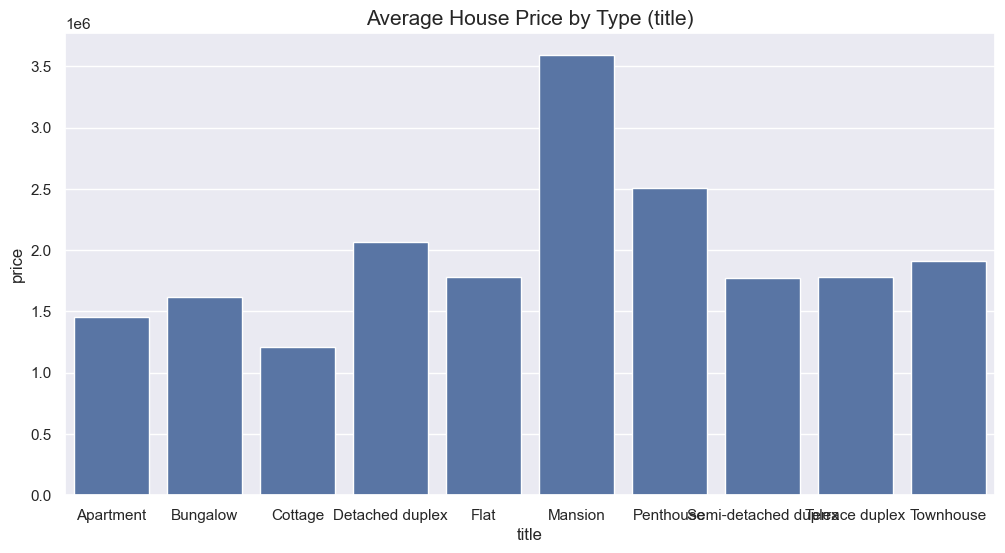

In [33]:
# answering the first question

plt.figure(figsize= (12, 6))
sns.barplot(data = housing_data_train.groupby("title")["price"].median().reset_index(), x = "title", y = "price")
plt.title("Average House Price by Type (title)", fontsize = 15)
plt.show()

Mansions are the most expensive houses while cotages are the least expensive. It appears the price of a house is determined by size.

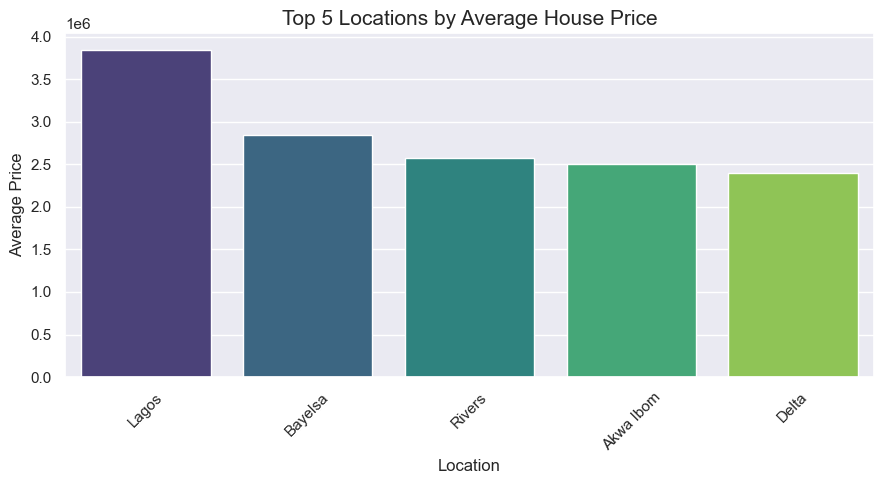

In [39]:
# What are the top 5 locations with the most expensive houses?

location_price_median = housing_data_train.groupby("loc")["price"].median().reset_index()

top_5_locations = location_price_median.sort_values(by="price", ascending=False).head(5)

plt.figure(figsize=(9, 5))
sns.barplot(data=top_5_locations, x="loc", y="price", palette="viridis")
plt.title("Top 5 Locations by Average House Price", fontsize=15)
plt.xlabel("Location", fontsize=12)
plt.ylabel("Average Price", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Lagos leads the pack, expectedly so. Rivers is in top three. However, a surprising insight is that houses are more expensive in Bayelsa than in Rivers.

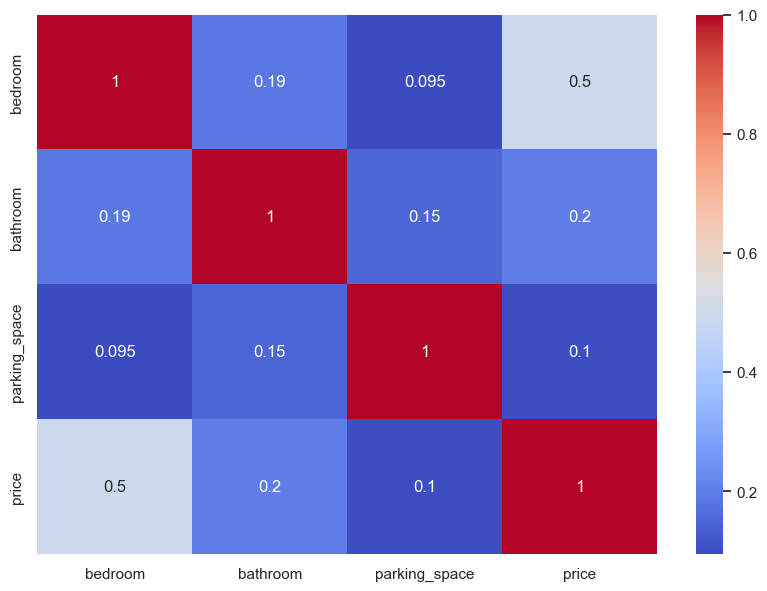

In [44]:
# Which of bedroom, bathroom, and parking space is more likely to spike the price of a house if they are high?
# Here, we take the correlation of these numeric variables

numeric_house_spec = housing_data_train.select_dtypes(include='number').drop(columns=['ID'])

plt.figure(figsize = (10, 7))
sns.heatmap(numeric_house_spec.corr(), cmap = "coolwarm", annot = True)
plt.show()

It looks like the more bedroom a house has, the more likely it is to be expensive. 

More bathrooms or a bigger (or more) parking space does not appear to influence the price of a house that much.

Now, moving on to model deployment

# Model development

This stage will involve 'feature encoding', scaling, and model training. I will put these processes in a model pipeline

__feature encoding__

Ensuring all the fields we will be feeding to the model are numeric. ML models only accept numeric values.

So, we need to convert fields like 'loc' and 'title' to numeric- this process is called feature encoding.

I will use one-hot encoding in this feature encoding process. I am favouring it above label encoding because, considering that there are so many categories (36), label encoding will introduce order where there is none. 

In this usecase, looking at the loc column for example, there is no information to suggest that one state comes higher in the heirachy than another. One-hot encoding does have its drawback, as it can result in the curse of dimensionality but, because this is just a test project, I'll favour it above label-encoding. Even the 'title' field showing the different house types, can be interpreted more as a matter of preference in this use-case, than as one house-type being higher than another (Not to say that this cannot be the case, but, let's work with the assumption that this is not the case)

before then, I will split the dataset into feature variables and target variable before proceeding with the remaining steps in this model development process. Also, we will not be needing the ID column so, I'll drop it alongside

__feature scalling__

I will use normalisation for scaling numeric features here. This is because we are dealing with a regression problem i.e., the target variable we are predicting, 'price', is a continous variable. Hence, the scaling algorithm I will ise is the Min-Max Scaler. This helps to ensures that no single feature dominates others due to its size, making our model training more effective

__model traiing__

I will experiment with a number of regression algorithms and select the one that gives us the best performing model.

Let's get on it.

In [46]:
# First, splitting the training data into feature and target variables

X_train = housing_data_train.drop(["ID", "price"], axis = 1)
y_train = housing_data_train["price"]

In [47]:
X_train.head()

,loc,title,bedroom,bathroom,parking_space
0,Katsina,Semi-detached duplex,2.0,2.0,1.0
1,Ondo,Apartment,4.0,2.0,4.0
2,Ekiti,Flat,7.0,5.0,3.0
3,Anambra,Detached duplex,5.0,2.0,4.0
4,Kogi,Terrace duplex,4.0,5.0,6.0


In [48]:
# Instantiating the models

lr_model = LinearRegression()
ls_model = Lasso(random_state=42)
rf_model = RandomForestRegressor(random_state=42)
ad_model = AdaBoostRegressor(random_state=42)
kn_model = KNeighborsRegressor()

In [50]:
models = {"Linear_regression_model": lr_model, 
          "Lasso_model": ls_model, 
          "RandomForest_model": rf_model, 
          "Adaboost_model": ad_model, 
          "KNN_model": kn_model}

In [51]:
# evaluating the models from the algorithms.

def create_and_evaluate_pipeline(X_train, y_train, models):

    # Evaluating each model
    for name, model in models.items():
        pipeline = create_pipeline(X_train, y_train, model)
        
        # Calculating the R2 score for training data
        train_score = pipeline.score(X_train, y_train)
        print(f"The R2 training score for {name} is {train_score:.4f}\n")
        
        # Making predictions on the training data
        y_train_pred = pipeline.predict(X_train)
        
        # Calculating regression metrics on the training data
        rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        mae = mean_absolute_error(y_train, y_train_pred)
        r2 = r2_score(y_train, y_train_pred)
        
        print(f"{name} Regression Metrics on Training Data:")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"R2: {r2:.4f}")
        print("------------------------\n")


create_and_evaluate_pipeline(X_train, y_train, models)

The R2 training score for Linear_regression_model is 0.7247

Linear_regression_model Regression Metrics on Training Data:
RMSE: 568202.5438
MAE: 302883.4741
R2: 0.7247
------------------------

The R2 training score for Lasso_model is 0.7247

Lasso_model Regression Metrics on Training Data:
RMSE: 568202.5451
MAE: 302879.2587
R2: 0.7247
------------------------

The R2 training score for RandomForest_model is 0.9168

RandomForest_model Regression Metrics on Training Data:
RMSE: 312367.9597
MAE: 152742.9524
R2: 0.9168
------------------------

The R2 training score for Adaboost_model is 0.4126

Adaboost_model Regression Metrics on Training Data:
RMSE: 830053.0681
MAE: 583778.2718
R2: 0.4126
------------------------

The R2 training score for KNN_model is 0.7825

KNN_model Regression Metrics on Training Data:
RMSE: 505084.8861
MAE: 302539.3096
R2: 0.7825
------------------------



From the above result, the random forest algorithm produces the best performing model.

It has the highest R2 score (0.9168) and the lowest root mean square error- RMSE (312367.9597) and mean absolute error- MAE (152742.9524). This model makes predictions with the least error.

__Improving our model's performance- Hyperparameter tuning to get the best parameters__

This process will adjust model settings to give us what hyperparaters lead to the best performing model

In [64]:
# # We will prefix each param with 'model__', 
# # because we are using a pipeline and whatever is connected to any of the steps in a pipeline have to be appropriately named.

# rforest_params = {'model__n_estimators': [200, 400, 600, 800, 1000],
#                   'model__max_depth': [None, 10, 20, 30, 40, 50],
#                   'model__min_samples_split': [6, 8, 10, 12],
#                   'model__min_samples_leaf': [3, 4, 5],
#                   'model__max_features': ['sqrt'],
#                   'model__bootstrap': [True, False]}


In [61]:

# # Instantiating RandomizedSearchCV with the trial parameters for random forest

# # PS: Had to settle for randomised gridsearch because full gridsearch was too computationaly expensive for my device- 
# # in enterprise-grade model development, a cloud platform offering model training capabilites, is advised for hyperparameter tuning

# pipeline = create_pipeline(X_train, y_train, rf_model)

# rfrandom_grid = RandomizedSearchCV(estimator = pipeline, param_distributions = rforest_params, n_iter = 100, cv = 10, random_state=42)

# rf_model_result = rfrandom_grid.fit(X_train, y_train)

# # Getting the best score based on the best parameters

# best_score, best_params = rf_model_result.best_score_, rf_model_result.best_params_
# print(f"Best score: {best_score} was obtained with these parameters: {best_params}")

# # Getting the model with the best estimator

# best_model = rf_model_result.best_estimator_

# tried hyperparameter tuning but it was too compuationally expensive for my device


In [62]:
# training only the random forest model and saving it for deployment

pipeline = create_pipeline(X_train, y_train, rf_model)

print(pipeline.score(X_train, y_train))

joblib.dump(pipeline, 'model/model_v1.joblib')

0.9168118195094166


['model/model_v1.joblib']